In [1]:
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 643.1 kB/s eta 0:00:17
   -- ------------------------------------- 0.8/11.1 MB 843.4 kB/s eta 0:00:13
   -- ------------------------------------- 0.8/11.1 MB 843.4 kB/s eta 0:00:13
   --- ------------------------------------ 1.0/11.1 MB 767.1 kB/s eta 0:00:14
   ---- ----------------------------------- 1.3/11.1 MB 776.4 kB/s eta 0:00:13
   ----- ---------------------------------- 1.6/11.1 MB 841.8 kB/s eta 0:00:12
   ----- ---------------------------------- 1.6/11.1 MB 841.8 kB/s eta 0:00:12
   ------ --------------------------------- 1.8/11.1 MB 824.7 kB/s eta 0:00:12
   -------

CustomerID: C0073, Similarity Score: 0.5021
CustomerID: C0066, Similarity Score: 0.5251
CustomerID: C0023, Similarity Score: 0.5556

Products purchased by Customer C0051: ['P067' 'P016' 'P017' 'P006' 'P083' 'P091' 'P098']

Recommended Customer C0073:
  Products purchased: ['P054' 'P017' 'P091']
  Demographic (Region): Europe
  Similarity Score: 0.5021

Recommended Customer C0066:
  Products purchased: ['P041' 'P083' 'P080']
  Demographic (Region): Europe
  Similarity Score: 0.5251

Recommended Customer C0023:
  Products purchased: ['P041' 'P032' 'P017' 'P066' 'P083' 'P012']
  Demographic (Region): Europe
  Similarity Score: 0.5556


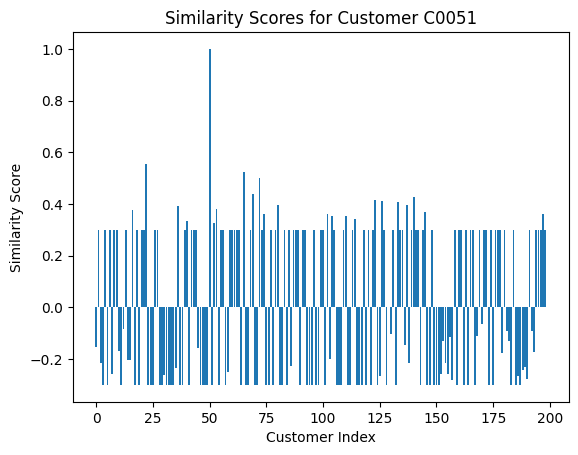

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load Data (Replace these with actual file paths or dataframe names)
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge customer and transaction data
transaction_details = pd.merge(transactions, products, on='ProductID', how='left')
transaction_details = pd.merge(transaction_details, customers, on='CustomerID', how='left')

# Create a customer-product interaction matrix
customer_product_matrix = transaction_details.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', aggfunc='sum', fill_value=0)

# Normalize the customer-product matrix if needed (Optional step)
# customer_product_matrix = customer_product_matrix / customer_product_matrix.sum(axis=1)

# Calculate Cosine Similarity between customers (Transaction History)
cosine_sim_transaction = cosine_similarity(customer_product_matrix)

# Handle customer profile data (e.g., Region, SignupDate) and create a customer profile matrix
# Encode categorical features like Region and SignupDate
label_encoder = LabelEncoder()
customers['Region_encoded'] = label_encoder.fit_transform(customers['Region'])

# Create a customer profile matrix (We will consider Region as an example for simplicity)
customer_profile_matrix = customers[['Region_encoded']].values

# Scale the customer profile matrix to make sure all features are comparable
scaler = StandardScaler()
customer_profile_matrix_scaled = scaler.fit_transform(customer_profile_matrix)

# Calculate Cosine Similarity based on Customer Profile (e.g., Region, SignupDate)
cosine_sim_profile = cosine_similarity(customer_profile_matrix_scaled)

# Ensure both similarity matrices are of the same shape by aligning customer IDs
# We will align the customer-product matrix and customer-profile matrix on the CustomerID
common_customers = customer_product_matrix.index.intersection(customers['CustomerID'])

# Reindex both cosine similarity matrices to ensure they only have common customers
cosine_sim_transaction = cosine_sim_transaction[customer_product_matrix.index.isin(common_customers)]
cosine_sim_transaction = cosine_sim_transaction[:, customer_product_matrix.index.isin(common_customers)]

cosine_sim_profile = cosine_sim_profile[customers['CustomerID'].isin(common_customers)]
cosine_sim_profile = cosine_sim_profile[:, customers['CustomerID'].isin(common_customers)]

# Combine both similarities (Weighted Sum)
# We are giving 70% weight to transaction history and 30% weight to customer profile similarity
combined_similarity = 0.7 * cosine_sim_transaction + 0.3 * cosine_sim_profile

# Function to recommend similar customers
def recommend_similar_customers(customer_id, num_recommendations=3):
    # Find the index of the customer in the matrix
    customer_idx = customer_product_matrix.index.get_loc(customer_id)
    
    # Get similarity scores for the given customer
    similarity_scores = combined_similarity[customer_idx]
    
    # Get the top N similar customers (excluding the customer itself)
    similar_customer_indices = similarity_scores.argsort()[-(num_recommendations+1):-1]
    
    # Get the customer IDs of the most similar customers
    similar_customers = customer_product_matrix.index[similar_customer_indices]
    
    # Create a dictionary of customer IDs and their similarity scores
    recommendations = {}
    for idx in similar_customer_indices:
        recommendations[customer_product_matrix.index[idx]] = similarity_scores[idx]
    
    return recommendations

# Example usage: Recommend similar customers for a given customer ID
customer_id_input = 'C0051'  # Input customer ID (replace with actual customer ID from your data)
recommendations = recommend_similar_customers(customer_id_input)

# Display results
for customer, score in recommendations.items():
    print(f"CustomerID: {customer}, Similarity Score: {score:.4f}")

# Logical Evaluation: Check the recommended customers' product similarity and demographics
def evaluate_recommendations(customer_id_input, recommendations):
    # Retrieve the customer and their product purchases
    customer_transactions = transaction_details[transaction_details['CustomerID'] == customer_id_input]
    customer_products = customer_transactions['ProductID'].unique()
    
    # Display the products purchased by the input customer
    print(f"\nProducts purchased by Customer {customer_id_input}: {customer_products}")
    
    # Check the recommended customers' product purchases and demographics
    for customer, score in recommendations.items():
        # Get the transactions for the recommended customer
        recommended_transactions = transaction_details[transaction_details['CustomerID'] == customer]
        recommended_products = recommended_transactions['ProductID'].unique()
        
        # Get the demographics of the recommended customer
        recommended_region = customers[customers['CustomerID'] == customer]['Region'].iloc[0]
        
        print(f"\nRecommended Customer {customer}:")
        print(f"  Products purchased: {recommended_products}")
        print(f"  Demographic (Region): {recommended_region}")
        print(f"  Similarity Score: {score:.4f}")
        
# Evaluate recommendations for the input customer
evaluate_recommendations(customer_id_input, recommendations)

# Visualizing the similarity scores for the input customer (optional)
similarity_scores = combined_similarity[customer_product_matrix.index.get_loc(customer_id_input)]
plt.bar(range(len(similarity_scores)), similarity_scores)
plt.title(f"Similarity Scores for Customer {customer_id_input}")
plt.xlabel("Customer Index")
plt.ylabel("Similarity Score")
plt.show()
